In [1]:
import numpy as np
from scipy.optimize import minimize
from scipy import integrate as ig

import myfun as mf

import matplotlib
import matplotlib.pyplot as plt

import emcee
import corner

import autograd.numpy as np
from autograd import grad, jacobian, hessian

import h5py

import os
os.environ["OMP_NUM_THREADS"] = "1"
from multiprocessing import Pool

In [2]:
datdir  = '/Users/simonfreedman/cqub/modeling_workshop/data'
plotdir = '/Users/simonfreedman/cqub/modeling_workshop/plots'

dat = np.load('{0}/action_pot.npy'.format(datdir))
th_guess = np.load('{0}/th_guess.npy'.format(datdir))
th_true  = np.load('{0}/th_true.npy'.format(datdir))

In [3]:
# INFRASTRUCTURE TO RUN THE MODEL

t0 = 0
tf = 100
ll_var = 1

all_params         = ['T','iext','a','b','v0','w0']
default_param_vals = [12.5,0.5,0.7,0.8,0,0]
default_param_bnds = [[1e-4,10],[1e-4,10],[-2,2],[-2,2],[-1,1],[-1,1]]
fit_param_idxs     = [1,2,3] # indexes of all_params to actually fit


default_param_dict = dict(zip(all_params, default_param_vals))
param_idx2th_idx   = dict(zip(fit_param_idxs, range(len(fit_param_idxs))))
set_param_idxs     = list(set(range(6)).difference(set(fit_param_idxs)))
fit_param_bnds     = [default_param_bnds[i] for i in fit_param_idxs] 

def param_dict(th):
    params = {all_params[i]:th[param_idx2th_idx[i]] for i in fit_param_idxs}
    params.update({all_params[i]:default_param_vals[i] for i in set_param_idxs})
    return params

def fitz_hugh_nagumo(t, vw, iext, a, b, T, **kwargs):
    v,w = vw
    return np.array([v - v**3/3 - w + iext, ( v + a - b*w ) / T])

def run_sim(th):    
    params = param_dict(th)
    fhn    = lambda t,vw: fitz_hugh_nagumo(t,vw,**params)
    dyn    = ig.solve_ivp(fhn, [t0,tf], [params['v0'],params['w0']], t_eval=np.arange(t0,tf,1))
    return np.array([dyn.t, dyn.y[0], dyn.y[1]])

In [4]:
traj_guess = run_sim(th_guess)
traj_true  = run_sim(th_true)

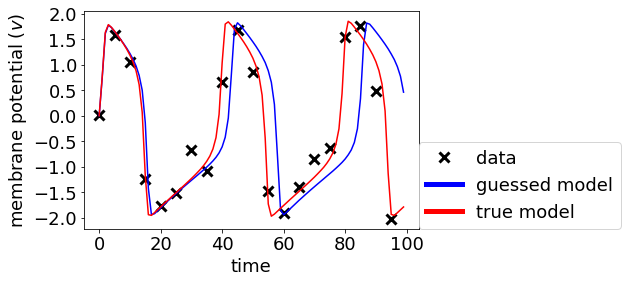

In [5]:
fig,axs=plt.subplots()
cols = plt.cm.tab20.colors

axs.plot(dat[:,0],dat[:,1],'kx', label = 'data', markersize=10, markeredgewidth=3)
axs.plot(traj_guess[0], traj_guess[1], 'b-', label = 'guessed model')
axs.plot(traj_true[0], traj_true[1], 'r-', label = 'true model')

leg = axs.legend(loc=(1,0),fontsize=18)

for legobj in leg.legendHandles:
    legobj.set_linewidth(5.0)
    
axs.set_xlabel('time')
axs.set_ylabel('membrane potential $(v)$')
mf.set_axs_fontsize(axs,18,False)

In [6]:
# INFRASTRUCE FOR CALCULATING THE POSTERIOR

def unif_logP(x,start,end):
    if x<start or x > end:
        return -np.inf # log(0)
    else:
        return 0 # arbitrary

def gaus_logP(x, mu, var):
    return -(x-mu)**2/var

param_log_priors = {
    'T'   : lambda x: unif_logP(x, 1,100),
    'iext': lambda x: unif_logP(x, 0, 10),
    'a'   : lambda x: gaus_logP(x, 0, 2),
    'b'   : lambda x: gaus_logP(x, 0, 2),
    'v0'  : lambda x: gaus_logP(x, 0, 0.1),
    'w0'  : lambda x: gaus_logP(x, 0, 0.1)
}

def log_likelihood(th, ts, vs, var):
    _,vsol,_ = run_sim(th)
    ll        = -np.sum((vs - vsol[ts])**2/var)
    if np.isnan(ll):
        return -np.inf
    return ll

def log_prior(th):
    params = param_dict(th)
    prior_tot = 0
    for k,v in params.items():
        prior_tot += param_log_priors[k](v)

    return prior_tot

def log_post(th, ts, vs, var):
    lp = log_prior(th)
    if not np.isfinite(lp):
        return -np.inf
    return log_likelihood(th, ts, vs, var) + lp

# DIFFERENTIABLE VERSIONS OF THE SIMULATION, LIKELIHOOD, POSTERIOR FOR AUTOGRAD PURPOSES

def run_sim_d(th, dt):
    params = param_dict(th)
    vs = [params['v0']]
    ws = [params['w0']]
    nt = int((tf-t0)/dt+1)
    
    for t in range(0, nt):
        vs.append(vs[t] + dt * (vs[t] - vs[t]**3/3 - ws[t] + params['iext']))
        ws.append(ws[t] + dt * (vs[t+1] + params['a'] - params['b']*ws[t]) / params['T'])
    
    return np.array([vs[0::int(1/dt)],ws[0::int(1/dt)]])

def log_likelihood_d(th, ts, vs, var):
    vsol,wsol = run_sim_d(th,0.1)
    ll        = -np.sum((vs - vsol[ts])**2/var)
    if np.isnan(ll):
        return -np.inf
    return ll

def log_post_d(th, ts, vs, var):
    lp = log_prior(th)
    if not np.isfinite(lp):
        return -np.inf
    return log_likelihood_d(th, ts, vs, var) + lp

def nlpost(th):
    return -log_post_d(th, np.array(dat[:,0],dtype='int'), dat[:,1], ll_var)

dnlpost  = jacobian(nlpost)
ddnlpost = hessian(nlpost)

In [7]:
fit_soln = minimize(nlpost, x0=th_guess, jac = dnlpost, hess = ddnlpost, 
                         bounds  = fit_param_bnds, method='trust-constr', options={'maxiter':20})

In [8]:
traj_fit_jh = run_sim(fit_soln.x)

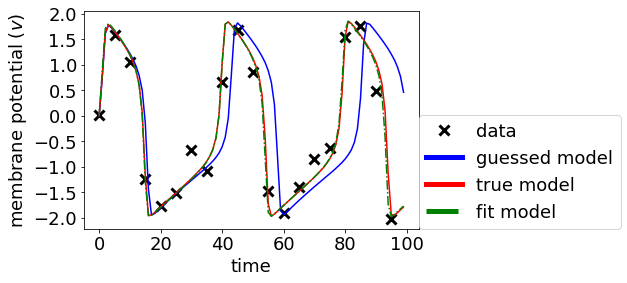

In [9]:
fig,axs=plt.subplots()
cols = plt.cm.tab20.colors

axs.plot(dat[:,0],dat[:,1],'kx', label = 'data', markersize=10, markeredgewidth=3)
axs.plot(traj_guess[0], traj_guess[1], 'b-', label = 'guessed model')
axs.plot(traj_true[0], traj_true[1], 'r-', label = 'true model')
axs.plot(traj_fit_jh[0], traj_fit_jh[1], 'g-.', label = 'fit model')


leg = axs.legend(loc=(1,0),fontsize=18)

for legobj in leg.legendHandles:
    legobj.set_linewidth(5.0)
    
axs.set_xlabel('time')
axs.set_ylabel('membrane potential $(v)$')
mf.set_axs_fontsize(axs,18,False)

In [10]:
nwalkers = 32
ndim     = len(fit_param_idxs)
nsteps   = 200

pos      = th_guess + np.abs(1e-4 * np.random.randn(nwalkers,ndim))

with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_post, args=( np.array(dat[:,0], dtype='int'), dat[:,1], 1), pool=pool)
    sampler.run_mcmc(pos, nsteps, progress=True);

100%|██████████| 200/200 [01:14<00:00,  2.69it/s]


In [11]:
chain=sampler.get_chain()
err = sampler.get_log_prob()

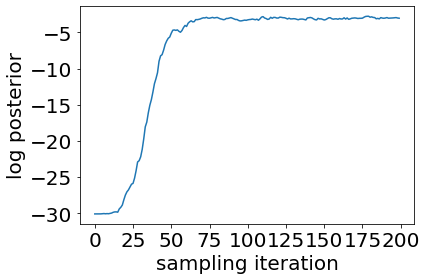

In [21]:
fig,axs=plt.subplots(1,1)
axs.plot(np.mean(err,axis=1))
axs.set_xlabel('sampling iteration')
axs.set_ylabel('log posterior')
mf.set_axs_fontsize(axs,20)
plt.show()

Text(0.5, 0, 'step number')

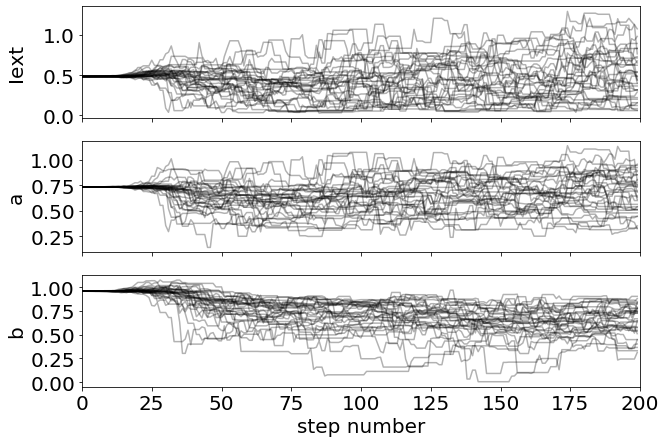

In [49]:
fig, axes = plt.subplots(len(fit_param_idxs), figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["Iext","a","b","v0","w0"]#["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    mf.set_axs_fontsize(ax,20)

axes[-1].set_xlabel("step number")

In [14]:
best_samp_idx = np.unravel_index(np.argmax(err,axis=None),err.shape)
best_samp_th  = chain[best_samp_idx]

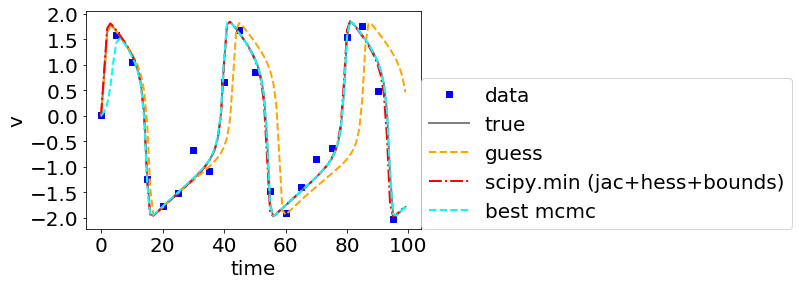

In [19]:
ths   = [th_true, th_guess, fit_soln.x, best_samp_th]
sims  = [run_sim(th) for th in ths]

fig,axs=plt.subplots()

labs = ['true', 'guess', 'scipy.min (jac+hess+bounds)', 'best mcmc']
cols = ['gray', 'orange','red','cyan']
lss = ['-','--','-.','--']
axs.plot(dat[:,0],dat[:,1], 'bs', label='data')
for i in range(0,len(sims)):
    axs.plot(sims[i][0], sims[i][1], color=cols[i], label = labs[i], lw=2, ls = lss[i])
    
axs.legend(loc=(1,0),fontsize=20)

axs.set_xlabel('time')
axs.set_ylabel('v')
mf.set_axs_fontsize(axs,20)

In [23]:
big_sampler = emcee.backends.HDFBackend('{0}/sampling.h5'.format(datdir)) # ran on quest 100k iter / 20 hours
errs2       = np.array(big_sampler.get_log_prob())
samples2    = big_sampler.get_chain()

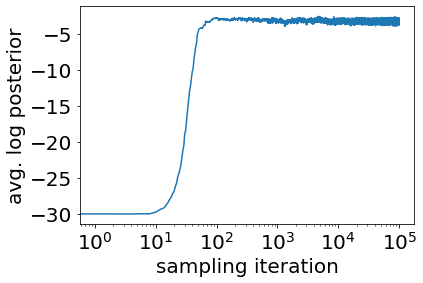

In [25]:
fig,axs=plt.subplots()
axs.plot(np.mean(errs2,axis=1))
axs.set_xscale('log')
axs.set_xlabel('sampling iteration')
axs.set_ylabel('avg. log posterior')
mf.set_axs_fontsize(axs,20)

Text(0.5, 0, 'step number')

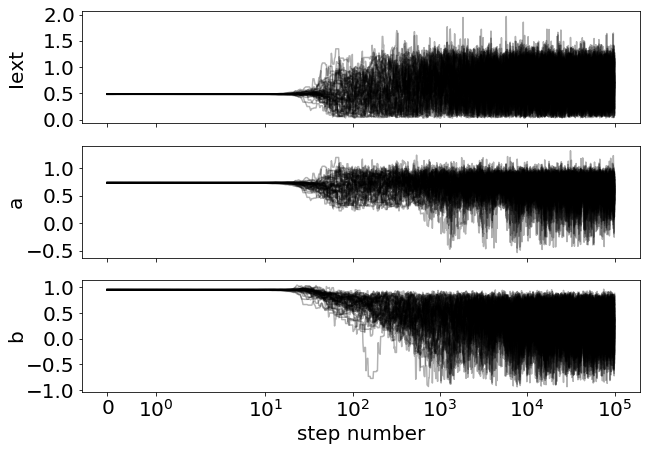

In [46]:
fig, axes = plt.subplots(len(fit_param_idxs), figsize=(10, 7), sharex=True)
labels = ["Iext","a","b"]
iters = np.arange(10**5)
idxs = np.unique(np.array(np.logspace(0,5,1000),dtype='int'))-1
for i in range(ndim):
    ax = axes[i]
    ax.plot(iters[idxs],samples2[idxs, :, i], "k", alpha=0.3)
    #ax.set_xlim(0, len(samples2))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

    ax.set_xscale('symlog')
    mf.set_axs_fontsize(ax,20)
axes[-1].set_xlabel("step number")

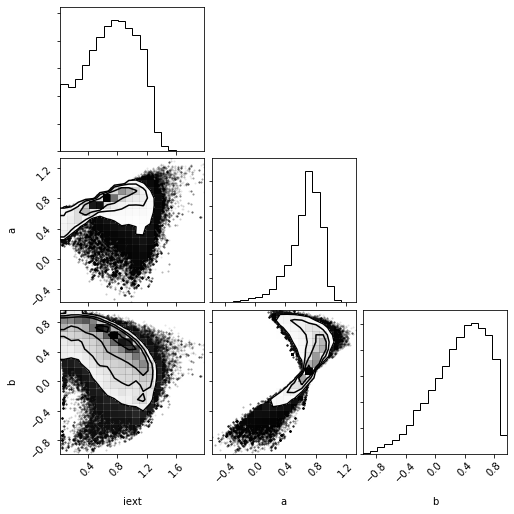

In [51]:
flat_samples = samples2[90000:].reshape((-1,samples2.shape[-1]))
figure = corner.corner(flat_samples, labels=np.array(all_params)[fit_param_idxs]);

In [54]:
hi_prob_thresh = -2
hi_prob_idxs   = np.array(np.where(errs2>hi_prob_thresh)).T
hi_prob_ths    = np.unique(samples2[hi_prob_idxs[:,0], hi_prob_idxs[:,1]],axis=0)

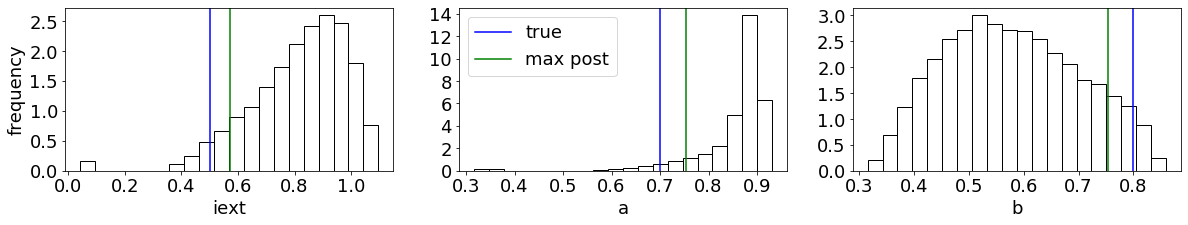

In [55]:
fig,axs=plt.subplots(1,ndim,figsize=(20,3))
for i in range(ndim):
    axs[i].hist(hi_prob_ths[:,i],20, fill=False, density=True)
    axs[i].set_xlabel(np.array(all_params)[fit_param_idxs][i])
    axs[i].axvline(th_true[i], color = 'blue', label='true')
    axs[i].axvline(fit_soln.x[i], color = 'green', label='max post')

    #axs[i].set_yscale('symlog')

axs[1].legend(fontsize=18)
axs[0].set_ylabel('frequency')

for ax in axs:
    mf.set_axs_fontsize(ax,18)

In [66]:
hi_prob_thresh = -1.8
hi_prob_idxs   = np.array(np.where(errs2>hi_prob_thresh)).T
hi_prob_ths    = np.unique(samples2[hi_prob_idxs[:,0], hi_prob_idxs[:,1]],axis=0)
hi_prob_ths.shape

(767, 3)

In [59]:
sims = np.array([run_sim(th) for th in hi_prob_ths])

In [61]:
sims_mu = np.mean(sims,axis=0)
sims_min = np.min(sims,axis=0)
sims_max = np.max(sims,axis=0)

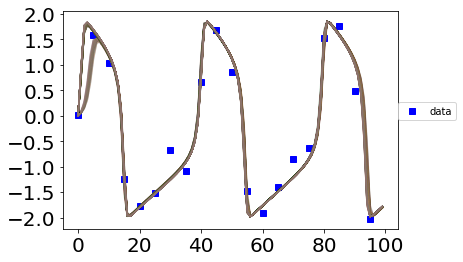

In [63]:
fig,axs=plt.subplots()

axs.plot(dat[:,0],dat[:,1], 'bs', label='data')
# for sim in [sims_min, sims_mu, sims_max]:
#     axs.plot(sim[0],sim[1])
for i in range(0,len(sims)):
    axs.plot(sims[i,0], sims[i,1], alpha=0.1)
    
axs.legend(loc=(1,0.5))

mf.set_axs_fontsize(axs,20)